In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from multiprocessing import cpu_count

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import RepeatedKFold, LeaveOneOut
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

In [13]:
df = pd.read_csv("data/p1_result.csv")

In [14]:
df

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X22,X23,X24,X25,X26,X27,X28,X29,X30,Y
0,0.469268,1.734423,1.549334,1.538197,1.346863,0.454481,0.373489,2.245099,1.431991,1.816488,...,1.770619,1.949699,2.055778,2.201455,3.050421,1.888672,2.342902,2.512754,1.759974,1
1,0.935333,0.923294,0.906224,1.969681,2.340116,1.923606,0.922545,0.719501,1.726190,1.299945,...,2.686666,3.899208,3.448918,2.276606,3.771094,1.595614,1.710363,1.558767,1.872789,0
2,0.492130,0.580903,1.185668,0.886403,0.881313,0.940271,0.446835,1.868852,0.585176,4.603573,...,2.280149,1.778641,1.482084,1.760260,1.785335,2.617370,2.374175,3.443737,2.085616,0
3,0.127372,0.659117,0.921655,0.848541,1.141585,0.826644,0.983421,0.902963,0.460213,0.546057,...,1.008817,3.251382,2.391041,1.834803,2.797869,2.449461,1.192996,3.022956,1.744515,1
4,1.647348,2.469574,2.097046,2.039730,2.098868,0.994925,2.183180,2.653563,1.009218,1.676911,...,1.717888,2.082219,1.796464,1.782127,1.519039,2.334673,2.131556,1.560064,1.807898,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.177347,1.559926,1.555265,1.783002,1.418710,1.687776,0.662214,0.541682,0.553557,1.368848,...,1.242610,1.896740,2.620893,1.536692,1.330504,2.886819,2.097340,1.652891,1.729752,0
196,0.228478,0.635264,0.579711,2.440204,1.175370,0.870643,1.131463,2.814369,2.261986,1.465536,...,2.162099,1.593991,1.896950,1.573735,2.361818,2.032028,2.865482,1.756156,1.697568,1
197,0.521435,1.607676,1.484288,1.358792,1.466249,0.365970,4.319138,1.908750,1.307888,1.854810,...,2.425072,2.327061,6.069779,2.596403,3.350215,3.223310,2.415394,2.450559,2.506417,1
198,0.529545,0.592972,0.539338,1.303081,1.909446,0.620642,0.677534,0.341679,1.416601,2.099008,...,3.579281,1.446938,2.319496,1.607785,3.078582,3.211171,1.181402,3.587776,2.719180,0


In [18]:
#FUNCTIONS

#METRICS

def mspe(preds, gt):
    """Calculates the mean squared prediction error between a list of predictions, preds, and a list of ground truth labels, gt."""
    if len(preds) != len(gt): return ValueError("predictions and ground-truth vectors must be the same length!")
    preds,gt = preds.tolist(),gt.tolist()
    sse = sum([(gt[i] - preds[i])**2 for i in range(len(gt))])
    return sse/len(gt)

#PARALLELIZE

def run_cv(df: pd.DataFrame, cv_technique):
    """Runs cross validation scheme specified by cv_technique on data in df."""
    scores = {}
    metrics = {
        "mspe": make_scorer(mspe),
    }
    for model in [LogisticRegression(), LinearRegression()]:
        X,y = df.drop("Y", axis=1),df["Y"] #assuming only X and y are present.
        score = cross_validate(model, X, y, cv=cv_technique, scoring=metrics)
        scores[str(model)] = score
    return scores

#define high-level parallelization
def make_groups(num_reps: int, num_jobs: int):
    """Divides num_reps by num_jobs such that no group is more than one larger than another."""
    r = num_reps%num_jobs
    groupsize = int(num_reps/num_jobs)
    groups = []
    for i in range(num_jobs):
        if r > 0:
            groups.append(groupsize+1)
            r-=1
        else:
            groups.append(groupsize)
    return groups

def run_jobs(n_jobs: int, df: pd.DataFrame, cv_technique, n_repeats: int=10, n_splits: int=10):
    """High-level function which parallelizes run_cv for n_jobs."""
    reps = make_groups(n_repeats, n_jobs)
    results = Parallel(n_jobs=n_jobs)(delayed(run_cv)(df, r, n_splits, cv_technique) for r in reps) #this doesn't 
    return results

def aggregate_partitioned_results(scores: list):
    """Brings partitioned data back together under a model->metric->values dictionary structure."""
    model_results = {str(model_name):{"mspe":[]} for model_name in [LogisticRegression(),LinearRegression()]}
    for partition_n,partition_data in enumerate(scores):
        for model_n,model_name in enumerate(partition_data.keys()): #model_n is 0 indexed
            model_results[model_name]["mspe"].extend(partition_data[model_name]["test_mspe"])
    return model_results

In [19]:
cpu_count()

8

In [20]:
df = pd.read_csv("data/p1_result.csv")
n_repeats, n_jobs = 10, 4
reps = make_groups(n_repeats, n_jobs)

n_splits = 10
rkf = RepeatedKFold(n_repeats=n_repeats,n_splits=n_splits)
rkf_scores = Parallel(n_jobs=n_jobs)(delayed(run_cv)(df, rkf) for r in reps)

In [21]:
rkf_model_results = aggregate_partitioned_results(rkf_scores)

In [22]:
rkf_model_results

{'LogisticRegression()': {'mspe': [0.15,
   0.25,
   0.15,
   0.3,
   0.05,
   0.15,
   0.25,
   0.25,
   0.05,
   0.05,
   0.2,
   0.15,
   0.25,
   0.05,
   0.2,
   0.15,
   0.05,
   0.2,
   0.25,
   0.05,
   0.15,
   0.15,
   0.1,
   0.1,
   0.2,
   0.45,
   0.05,
   0.1,
   0.0,
   0.15,
   0.15,
   0.15,
   0.1,
   0.05,
   0.3,
   0.15,
   0.1,
   0.15,
   0.2,
   0.15,
   0.1,
   0.1,
   0.2,
   0.15,
   0.1,
   0.25,
   0.0,
   0.25,
   0.1,
   0.1,
   0.15,
   0.1,
   0.15,
   0.3,
   0.35,
   0.05,
   0.1,
   0.1,
   0.25,
   0.2,
   0.25,
   0.3,
   0.2,
   0.15,
   0.05,
   0.15,
   0.2,
   0.1,
   0.05,
   0.15,
   0.2,
   0.2,
   0.2,
   0.15,
   0.1,
   0.2,
   0.3,
   0.2,
   0.1,
   0.05,
   0.2,
   0.3,
   0.25,
   0.05,
   0.15,
   0.1,
   0.15,
   0.15,
   0.2,
   0.2,
   0.15,
   0.2,
   0.1,
   0.15,
   0.2,
   0.15,
   0.2,
   0.2,
   0.25,
   0.25,
   0.2,
   0.2,
   0.2,
   0.15,
   0.15,
   0.1,
   0.2,
   0.1,
   0.1,
   0.25,
   0.1,
   0.0,
   0.25,
   0.1,

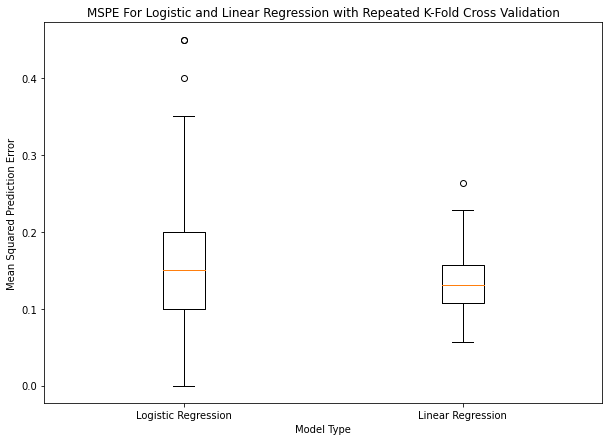

In [23]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

plt.boxplot([rkf_model_results['LogisticRegression()']['mspe'],rkf_model_results['LinearRegression()']['mspe']])
ax.set_xticklabels(['Logistic Regression', 'Linear Regression'])
plt.xlabel("Model Type")
plt.ylabel("Mean Squared Prediction Error")
plt.title("MSPE For Logistic and Linear Regression with Repeated K-Fold Cross Validation")
plt.savefig("plots/mspe_loglin_loo.png")

2b

In [37]:
# now I ~should~ be able to do a similar call for LOO! w/ repetitions
#TODO: no! just do it once...
loo = LeaveOneOut()
#loo_scores = run_cv(df, loo)


loo_scores = Parallel(n_jobs=n_jobs)(delayed(run_cv)(df, loo) for i in range(1)) #this looks cl
#rkf_scores = Parallel(n_jobs=n_jobs)(delayed(run_cv)(df, rkf) for r in reps)


#TODO: the problem is that LOO works for a single job, but doesn't parallelize successfully.
#additionally, the single job LOO won't aggregate for obv reasons, this goes away if you solve ^

#SoF says that it's a parenthesis problem... but my code works whenever I do the for range in...
#am I not applying jobs correctly?

In [38]:
loo_scores

[{'LogisticRegression()': {'fit_time': array([0.04933739, 0.05143285, 0.03143549, 0.03199744, 0.03842425,
          0.02754688, 0.03360748, 0.02760267, 0.04006243, 0.03537869,
          0.03676629, 0.0324955 , 0.03632593, 0.02804589, 0.03600001,
          0.02801061, 0.03198981, 0.02404404, 0.0319159 , 0.02808499,
          0.03201222, 0.02401614, 0.02796197, 0.02798772, 0.02730989,
          0.03594422, 0.03205061, 0.02049446, 0.03689575, 0.036376  ,
          0.03596711, 0.02795315, 0.04005575, 0.03593826, 0.03892517,
          0.02802896, 0.03189206, 0.03199458, 0.03199959, 0.02800035,
          0.02805805, 0.03599238, 0.02822852, 0.02801108, 0.02803564,
          0.02469134, 0.03199911, 0.02802968, 0.02788806, 0.04023194,
          0.03209567, 0.0320034 , 0.0239718 , 0.02398753, 0.02805543,
          0.02386546, 0.03203797, 0.02400017, 0.01999927, 0.02794003,
          0.02399635, 0.02800035, 0.02399993, 0.02800012, 0.02399564,
          0.02799559, 0.03272724, 0.03202748, 0.019966

In [39]:
loo_model_results = aggregate_partitioned_results(loo_scores) #doesn't work bc no repetitions?

In [40]:
loo_model_results

{'LogisticRegression()': {'mspe': [0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,


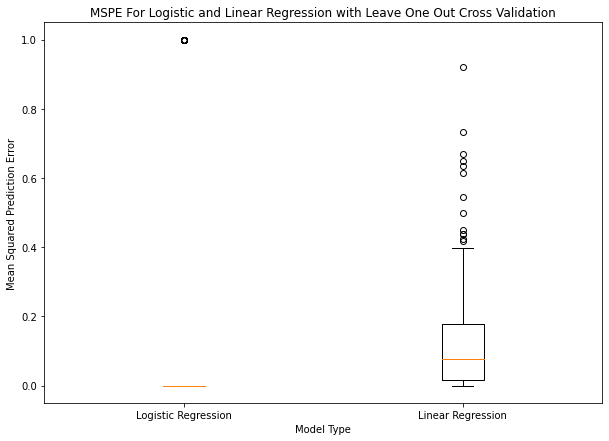

In [41]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

plt.boxplot([loo_model_results['LogisticRegression()']['mspe'],loo_model_results['LinearRegression()']['mspe']])
ax.set_xticklabels(['Logistic Regression', 'Linear Regression'])
plt.xlabel("Model Type")
plt.ylabel("Mean Squared Prediction Error")
plt.title("MSPE For Logistic and Linear Regression with Leave One Out Cross Validation")
plt.savefig("plots/mspe_loglin_loo.png")